In [1]:
import time
import copy
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from torchdp import PrivacyEngine

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

Warning! Tensorboard library was not found.


In [20]:
class Arguments:
    """Parameters for training"""
    def __init__(self):
        self.epochs = 50
        self.iterations = 1
        self.lr = 0.01
        self.shuffle_dataset = True
        self.batch_size = 128
        self.test_batch_size = 8
        self.log_interval = 10
        self.seed = 1
        self.disable_federated = True
        self.disable_dp = True
        self.alphas=[1.1, 2, 4, 10]
        self.delta = 1.0
        self.workers = 1
        self.disable_verbose_training = True
        self.no_cuda = True
    

args = Arguments()

torch.manual_seed(args.seed)
kwargs = {}

In [21]:
def load_adult(args):

    data_file = "/home/gwyn/dev/webapp/test/fed-iris/data/adult.data"
    data_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                  'marital-status', 'occupation', 'relationship', 'race', 
                  'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 
                  'native-country', 'income']

    dataframe = pd.read_csv(data_file, names=data_names)
    for i in dataframe.columns:
        dataframe[i].replace(' ?', np.nan, inplace=True)
    dataframe.dropna(inplace=True)
    dataframe.drop(['fnlwgt'], axis=1, inplace=True)

    # This needs to be run multiple times to capture all categorical data, for some reason
    for _ in range(1,5):
        for i in range(dataframe.shape[1]):
            # check if string data, skip if false
            if type(dataframe.iloc[1,i]) == str:
            # list uniques in column
                unique_classes = list(dataframe.iloc[: , i].unique())
            # add binary field for unique with true
                for unique_class in unique_classes:            
                    dataframe[unique_class.replace('-','').strip()] = dataframe.iloc[:,i] == unique_class
                dataframe.drop(axis=1, columns=dataframe.columns[i], inplace=True)

    X = np.array(dataframe.drop('>50K',axis=1).values, dtype='float64')
    y = np.array(dataframe['>50K'].values, dtype='float64')
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, shuffle=args.shuffle_dataset)
    
    return X_train, X_test, y_train, y_test

In [22]:
# separates data and labels and initialises data loaders
def prepare_data(X_train, X_test, y_train, y_test, batch_size, num_workers):

    # Initialise train_loaders list for storing each worker's train_loader
    train_loaders = list()

    # Split training data equally among all workers
    remote_X_train = list()
    remote_X_train.append(np.array_split(X_train, num_workers))

    # Split training labels equally among all workers
    remote_y_train = list()    
    remote_y_train.append(np.array_split(y_train, num_workers))

    # This looks like it's reinitialising these variables as their index 0 values,
    # but it's actually discarding an unwanted outer object layer so that we can directly 
    # reference the data/target lists.
    remote_X_train = remote_X_train[0]
    remote_y_train = remote_y_train[0]

    # Convert training data & labels into torch tensors, then into datasets, then into dataloaders
    for i in range(len(remote_X_train)):
        remote_X_train[i] = torch.tensor(remote_X_train[i]).float()
        remote_y_train[i] = torch.tensor(remote_y_train[i]).float()
        train = TensorDataset(remote_X_train[i], remote_y_train[i])
        train_loaders.append(DataLoader(train, batch_size=batch_size, shuffle=True))

    # Standard test loader setup as we only need one
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
    test = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

    return train_loaders, test_loader

In [23]:
# Set up a model, optimiser and renyi privacy engine for each worker (only call if DP is needed)
def prepare_private_training(device, model, train_loaders, num_workers, batch_size, alphas, lr):
    
    model_pool = list()
    optimizer_pool = list()
    priv_eng_pool = list()

    # We use deepcopy to make wholly independent copies of the shared model
    for _ in range (num_workers):
        model_pool.append(copy.deepcopy(model))

    # We call the SGD constructor each time to ensure model updates are correctly applied
    for model in model_pool:
        model.to(device)
        opt = optim.SGD(model.parameters(), lr=lr)
        optimizer_pool.append(opt)

    # Attaches privacy engine for each model to each optimiser, effectively replacing
    # gradient calculation functions with similar DP-enabled ones.
    for i in range(len(model_pool)):    
        privacy_engine = PrivacyEngine(
                            model_pool[i],
                            batch_size=batch_size,
                            sample_size=len(train_loaders[i].dataset),
                            alphas=alphas,
                            noise_multiplier = 1.0,
                            max_grad_norm = 1.0)

        privacy_engine.attach(optimizer_pool[i])

    return model_pool, optimizer_pool

In [24]:
# Set up a model and optimiser for each worker (only call if DP is not needed)
def prepare_training(device, model, train_loaders, num_workers, lr):
    
    model_pool = list()
    optimizer_pool = list()

    # We use deepcopy to make wholly independent copies of the shared model
    for _ in range (num_workers):
        model_pool.append(copy.deepcopy(model))

    # We call the SGD constructor each time to ensure model updates are correctly applied
    for model in model_pool:
        model.to(device)
        opt = optim.SGD(model.parameters(), lr=lr)
        optimizer_pool.append(opt)

    return model_pool, optimizer_pool

In [25]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(104, 20)
        self.fc2 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()
    
    # pass-forward procedure using a relu and a softmax output
    def forward(self, x):
        x = x.view(-1, 104)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [26]:
# Main model training routine
def train(device, model, optimizer, train_loader, epoch, i, disable_verbose_training, disable_dp, delta):
    model.train()

    # We will store the cross-entropy loss to report it later    
    losses = []

    # Standard pytorch training loop
    for _batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        pred = model(data)
        #print(pred.view(-1,).data)
        #print(target.view(-1,).data)
        loss = F.binary_cross_entropy(pred.view(-1,), target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if not disable_verbose_training:
        # If DP is enabled, show our data leakage as we go along with loss output
        if not disable_dp:
            epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(delta)
            print(
                    f"Model ID: {i:2d}   "
                    f"Train Epoch: {epoch:2d}   "
                    f"Loss: {np.mean(losses):.6f} "
                    f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}"
            )
        else:
            # If we are not using DP, just show the loss output 
            print(f"Model ID: {i:2d}   Train Epoch: {epoch:2d}   Loss: {np.mean(losses):.6f}")

In [27]:
# When all workers have trained their local models, bring models together and average them
def aggregate_models(device, models):

    params = list()
    num_workers = len(models)

    # Deep copying the model parameters directly makes them easier to work with
    for model_id in range(num_workers):
        params.append(list(copy.deepcopy(models[model_id]).parameters()))

        # Remove outer object layer of each parameter list so we can access it directly
        for layer_id in range(len(params[0])):
            params[model_id][layer_id] = params[model_id][layer_id].data

    agg_params = list()

    # Take the mean average of worker parameters at each model layer
    for layer_id in range(len(params[0])):

        agg_layer = params[0][layer_id]

        for worker_id in range(1, num_workers):
            agg_layer = agg_layer + params[worker_id][layer_id]

        agg_layer = agg_layer / num_workers
        agg_params.append(agg_layer)

    # Initialise new shared model to be used, and access parameters directly
    new_model = Net().to(device)
    new_params = list(new_model.parameters())

    # Turn off pytorch autograd and overwrite the new model parameters with the averaged params
    with torch.no_grad():
        for layer_index in range(len(new_params)):
            new_params[layer_index].set_(agg_params[layer_index])

    # This will be our new shared model for testing and further training
    return new_model

In [28]:
# Model Test routine
def test(data_loader, model):

    model.eval()
    test_loss = 0

    # Standard pytorch test loop
    for data, target in data_loader:
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability

    # We take the mean of the testing set loss        
    test_loss /= len(data_loader.dataset)

    # We could print the test loss output or just return it.
    # print('Test set: Average loss: {:.4f}\n'.format(test_loss))
    return test_loss

In [29]:
def select_prepare_training(device, init_model, train_loaders, args):
    # Case switch based on whether or not we want to use DP (see the Arguments class)
    if not args.disable_dp:
        models,opts = prepare_private_training(device, init_model, train_loaders, args.workers, args.batch_size, args.alphas, args.lr)
    else:
        models,opts = prepare_training(device, init_model, train_loaders, args.workers, args.lr)
    
    return models,opts

No GPU detected - training using CPU
Completed in 13.1857 seconds
Precision = 0.9324689346798392
Recall = 0.9258719002784777
F1 score = 0.9212581981556316


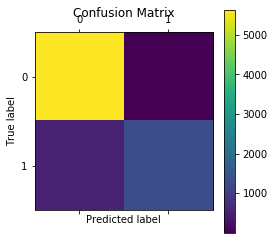

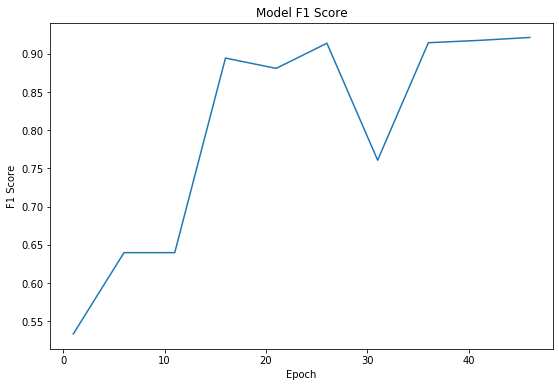

In [31]:
# We can enable cuda, but this small model runs faster on CPU
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("GPU training enabled" if use_cuda else "No GPU detected - training using CPU")

# Start the performance timer
start = time.perf_counter()

# TODO - update code so our net layers can be defined in Net constructor arguments
init_model = Net()

# Load UCI Adult Data Set - downloaded from http://archive.ics.uci.edu/ml/datasets/Adult
X_train, X_test, y_train, y_test = load_adult(args)

# TODO - implement test loaders and test function
train_loaders, _ = prepare_data(X_train, X_test, y_train, y_test, args.batch_size, args.workers)

# List to store our train-time f1 scoring
f1_scores = list()

# Case switch based on whether or not we want to use DP (see the Arguments class)
models,opts = select_prepare_training(device, init_model, train_loaders, args)

# Train all of our worker models on their local data, then combine and aggregate their models
for epoch in range(1,args.epochs+1):
    for i in range(len(models)):
        train(device, models[i], opts[i], train_loaders[i], epoch, i, args.disable_verbose_training, args.disable_dp, args.delta)
    new_model = aggregate_models(device, models)
    models,opts = select_prepare_training(device, new_model, train_loaders, args)
    
    # Every 5 epochs record the F1 Score of the aggregated model
    if (epoch%5)==0:
        with torch.no_grad():
            new_model.to(device='cpu')
            pred = np.array(new_model(torch.tensor(X_test).float()))
            y_pred = pred.reshape(-1,)[:] > 0.5
            y_test = y_test.reshape(-1,)[:] > 0.5
            f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
            new_model.to(device)

# Stop the performance timer and print
stop = time.perf_counter()
print(f"Completed in {stop-start:0.4f} seconds")
            
# Turn off pytorch autograd to run some metrics 
with torch.no_grad():
    # Numpy isn't CUDA compatible so bring the model back to the CPU
    new_model.to(device='cpu')
    
    # Convert model predictions to Numpy array of Boolean values
    pred = np.array(new_model(torch.tensor(X_test).float()))
    y_pred = pred.reshape(-1,)[:] > 0.5
    
    # Scikit-learn  metrics - Precision, Recall, F1 score
    print(f"Precision = {precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall = {recall_score(y_test, y_pred, average='weighted')}")
    print(f"F1 score = {f1_score(y_test, y_pred, average='weighted')}")

    # Create a confusion matrix to see how well we perform on Adult income prediction
    cm = confusion_matrix(y_test, y_pred)
    
    # Display confusion matrix
    plt.matshow(cm)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Plot graph of F1 Score history over all epochs
    plt.figure(figsize=(9,6))
    plt.plot(range(1,args.epochs+1,5),f1_scores)
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')